In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def ZBL(rij, Zi, Zj):

    const = 1/(4*np.pi*55.26349406e-4)

    a = 0.46850/(Zi**0.23 + Zj**0.23)

    x = rij/a

    phi = 0.18175*np.exp(-3.19980*x) + 0.50986*np.exp(-0.94229*x) + \
          0.28022*np.exp(-0.40290*x) + 0.02817*np.exp(-0.20162*x)
    
    return const*phi*(Zi*Zj/rij)

def LJ(r, epsilon, sigma):
    
    x = sigma/r
    E = 4*epsilon*(x**12 - x**6)
    return E

In [2]:
import os

cwd = os.getcwd()

folder = os.path.dirname(cwd)

folder = folder + '/'

129.91060738371053


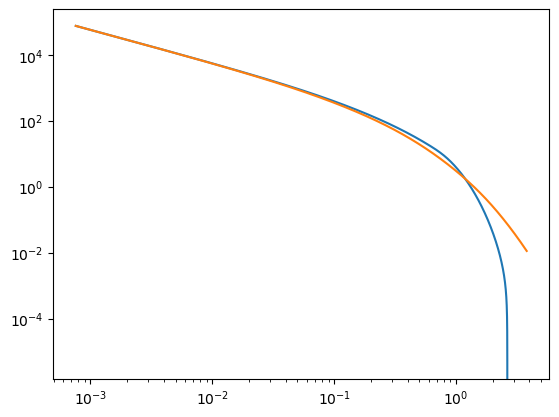

In [3]:
he_he = np.loadtxt('%sPotentials/He-Beck1968_modified.table' % folder,
                   skiprows=7)

plt.loglog(he_he[:,1], he_he[:,2])
plt.loglog(he_he[:,1], ZBL(he_he[:,1], 2, 2))
print(np.mean((he_he[:,2]-ZBL(he_he[:,1], 2, 2))**2))

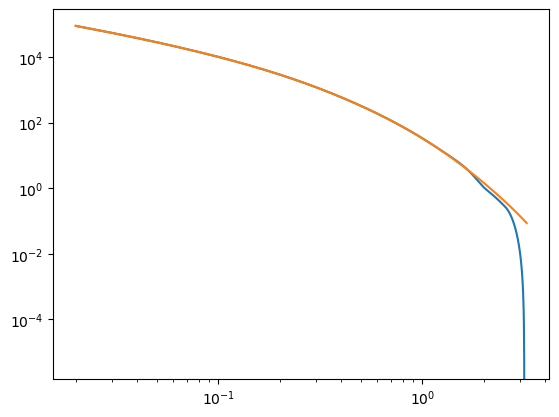

In [54]:
w_he = np.loadtxt('%sPotentials/W-He-Juslin.table' % folder, skiprows=7)

plt.loglog(w_he[:,1], w_he[:,2])
plt.loglog(w_he[:,1], ZBL(w_he[:,1], 74, 2))

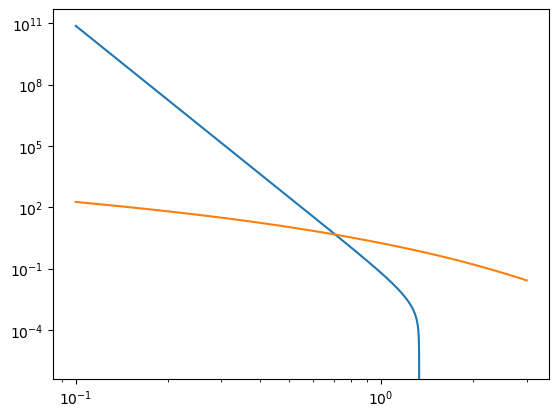

In [55]:
r = np.linspace(0.1, 3,5000)

he_h = LJ(r, 5.9225e-4, 1.333)

plt.plot(r, he_h)
plt.loglog(r, ZBL(r, 2, 1))

[-1.21273117  1.48848648 -5.7767475  -2.73489032  1.64986025  5.97630834] [-1.21273117  1.48848648 -5.7767475  -2.73489032  1.64986025  5.97630834]
[-1.21273117  1.48848648 -5.7767475  -2.73489032  1.64986025  5.97630834] [-1.21273117  1.48848648 -5.7767475  -2.73489032  1.64986025  5.97630834]
[-1.21273117  1.48848648 -5.7767475  -2.73489032  1.64986025  5.97630834] [-1.21273117  1.48848648 -5.7767475  -2.73489032  1.64986025  5.97630834]


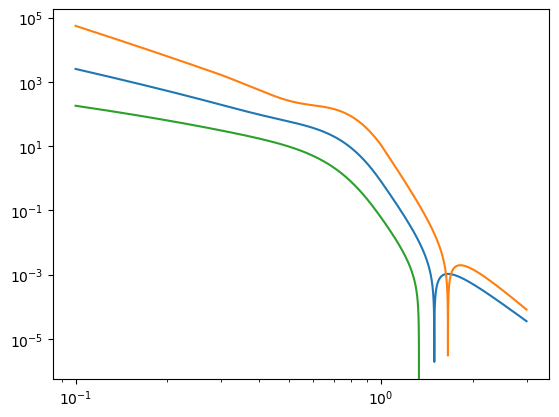

In [56]:

def spline_he_h(r, rz, rl):
    A = np.array([
            
            [rl**i for i in range(6)],
            [rz**i for i in range(6)],
            [i*rl**(i-1) for i in range(6)],
            [i*rz**(i-1) for i in range(6)],
            [np.clip(i*(i-1)*rl**(i-2), a_min = 0, a_max=np.inf) for i in range(6)],
            [np.clip(i*(i-1)*rz**(i-2), a_min = 0, a_max=np.inf) for i in range(6)],
])

    l = np.log10( LJ(rl,5.9225e-4, 1.333) )

    z = np.log10( ZBL(rz, 2, 1) )

    h = 1e-5

    dl = np.log10( LJ(rl + h,5.9225e-4, 1.333) ) - np.log10( LJ(rl - h,5.9225e-4, 1.333) )

    dz = np.log10( ZBL(rz + h, 2, 1) ) - np.log10( ZBL(rz - h, 2, 1) )

    d2l = np.log10( LJ(rl + h,5.9225e-4, 1.333) ) - 2*l + np.log10( LJ(rl - h, 5.9225e-4, 1.333) )

    d2z = np.log10( ZBL(rz + h, 2, 1) ) - 2*z + np.log10( ZBL(rz - h , 2, 1) ) 

    dl = 0.5*dl/h

    dz = 0.5*dz/h

    d2l = d2l/h**2

    d2z = d2z/h**2

    b = np.array([l, z, dl, dz, d2l, d2z])

    a = np.linalg.solve(A,b)
    print(b, A@a)

    E = np.zeros(r.shape)
    for idx, _r in enumerate(r):
        if _r < rz:
            E[idx] = ZBL(_r, 2, 1)
        elif _r > rl:
            E[idx] = LJ(_r,5.9225e-4, 1.333)
        else:
            E[idx] = 10**(a @ np.array([_r**i for i in range(6)]))
    return E, a

rz = 0.3
rl = 1
spline_pot, a = spline_he_h(r, rz, rl)

h = 1e-5
dspline_pot, a = spline_he_h(r+h, rz, rl)

d_spline_pot, a = spline_he_h(r-h, rz, rl)

plt.loglog(r, np.abs((dspline_pot - spline_pot)/h))
plt.loglog(r, np.abs((dspline_pot - 2*spline_pot + d_spline_pot)/(h**2)))
plt.loglog(r, spline_pot)
#plt.plot(r, he_h)
#plt.loglog(r, ZBL(r, 2, 1))

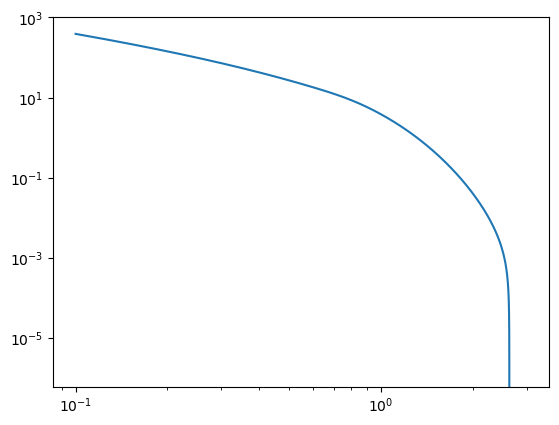

In [57]:
f = interp1d(he_he[:,1], he_he[:,2], kind = 'cubic')

plt.loglog(r, f(r))

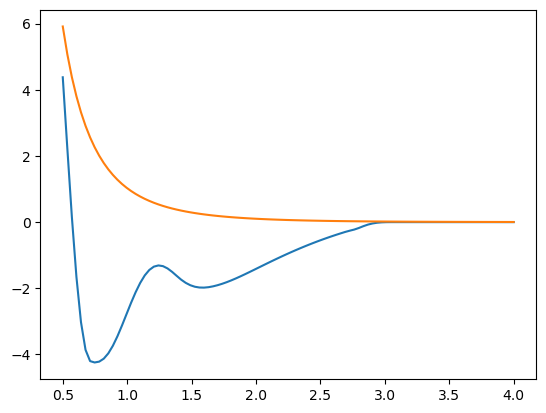

In [77]:
distance = np.loadtxt('%sData/Distance_22.txt' % folder)
h_h = np.loadtxt('%sData/Overlay_22.txt' % folder)

plt.plot(distance, h_h)
plt.plot(distance, ZBL(distance, 1, 1))

In [59]:
def spline_He_He(r):

    data = np.loadtxt('%sPotentials/He-Beck1968_modified.table' % folder,
                      skiprows=7)
    spline = interp1d(data[:,1], data[:,2])
    if r == 0:
        return 0.0
    
    if r < data[:,1].min():
        return ZBL(r, 2, 2)
    elif r > data[:,1].max():
        return 0.0
    else:
        return spline(r)


def spline_W_He(r):

    data = np.loadtxt('%sPotentials/W-He-Juslin.table' % folder, skiprows=7)
    spline = interp1d(data[:,1], data[:,2])

    if r == 0:
        return 0.0
    
    if r < data[:,1].min():
        return ZBL(r, 74, 2)
    elif r > data[:,1].max():
        return 0.0
    else:
        return spline(r)
    
def spline_H_He(r, a):
    
    if r == 0:
        return 0.0
    
    if r < rz:
        return ZBL(r, 2, 1)
        
    elif r > rl:
        return LJ(r,5.9225e-4, 1.333)
    else:
        return 10**(a @ np.array([r**i for i in range(6)]))
    

In [60]:
with open('%sW_H_He_0001.eam.alloy' % folder,'w') as file:

    file.write('# W-H-He potential \n')
    file.write('# \n')
    file.write('# \n')

    file.write('3 W H He \n')
    
    Nrho = 5000
    drho = 0.0020000000
    Nr   = 10000
    dr   = 0.0004650000
    cutoff  = 4.6500000954

    with open('%sPotentials/MNL6_WH.ZBLRMIN0_0001.eam.alloy' % folder, 'r') as ref:

        for i in range(4):
            ref.readline()
        
        line = ref.readline()
        file.write(line)
        
        line = ref.readline()
        file.write(line)

        for i in range(Nrho+Nr):

            line = ref.readline()
            file.write(line)

        line = ref.readline()
        file.write(line)

        for i in range(Nrho+Nr):

            line = ref.readline()
            file.write(line)
        
        #The lattice type and constant don't really matter for Helium
        file.write('2  4.0026        10.14484257  DIMER\n')

        for i in range(Nrho+Nr):

            file.write('%16.8f \n' % 0)
        
        for i in range(3*Nr):
            line = ref.readline()
            file.write(line)
        
        for i in range(Nr):

            r = i*dr
            E = r*spline_W_He(r)

            file.write('%16.8f \n' % E)
        
        for i in range(Nr):

            r = i*dr
            E = r*spline_H_He(r, a)

            file.write('%16.8f \n' % E)

        for i in range(Nr):

            r = i*dr
            E = r*spline_He_He(r)

            file.write('%16.8f \n' % E)



2.109424446718203


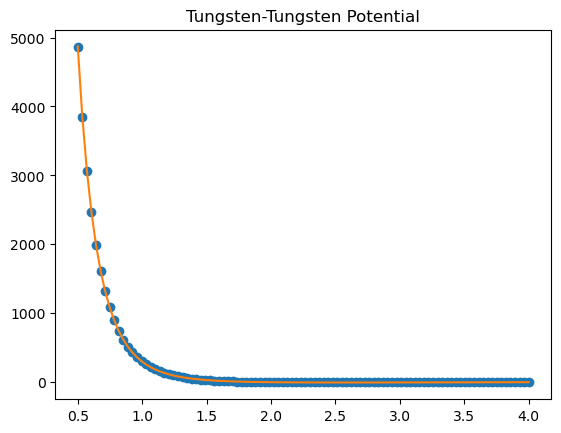

In [107]:
distance = np.loadtxt('%sData/Distance_11.txt' % folder)
w_w = np.loadtxt('%sData/Overlay_11.txt' % folder)
plt.plot(distance, w_w, 'o')
plt.plot(distance, np.loadtxt('%sData/EAM_11.txt' % folder))
plt.title('Tungsten-Tungsten Potential')

print(np.linalg.norm(w_w - np.loadtxt('%sData/EAM_11.txt' % folder)))

Text(0.5, 1.0, 'Tungsten-Hydrogen Potential')

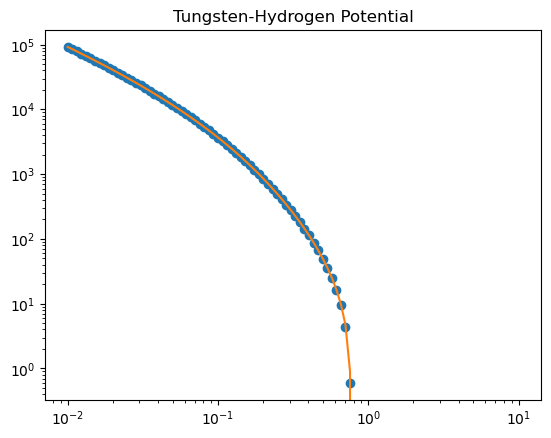

In [101]:
distance = np.loadtxt('%sData/Distance_12.txt' % folder)
w_w = np.loadtxt('%sData/Overlay_12.txt' % folder)
plt.loglog(distance, w_w, 'o')
plt.loglog(distance, np.loadtxt('%sData/EAM_12.txt' % folder))
plt.title('Tungsten-Hydrogen Potential')

Text(0.5, 1.0, 'Hydrogen-Hydrogen')

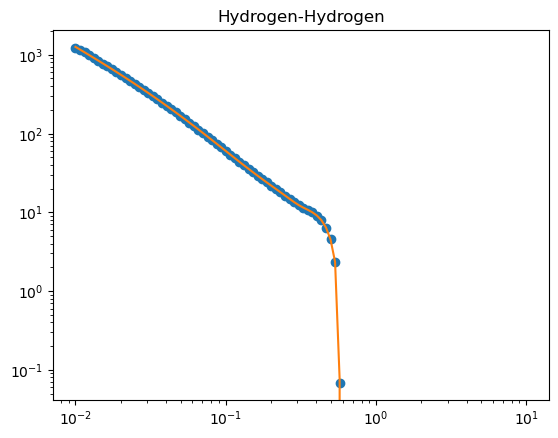

In [100]:
distance = np.loadtxt('%sData/Distance_22.txt' % folder)
w_w = np.loadtxt('%sData/Overlay_22.txt' % folder)
plt.loglog(distance, w_w, 'o')
plt.loglog(distance, np.loadtxt('%sData/EAM_22.txt' % folder))
plt.title('Hydrogen-Hydrogen')

Text(0.5, 1.0, 'Tungsten-Helium Potential')

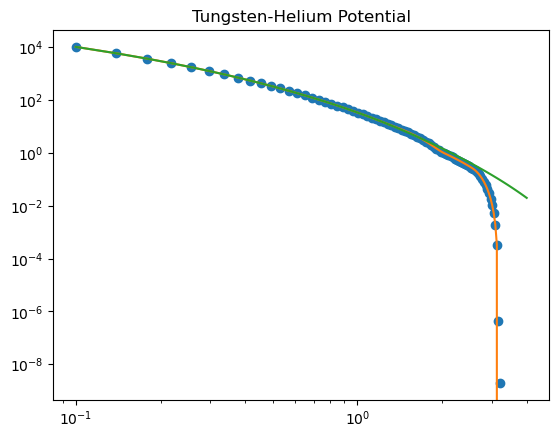

In [89]:
distance = np.loadtxt('%sData/Distance_13.txt' % folder)
w_he = np.loadtxt('%sData/Overlay_13.txt' % folder)

plt.loglog(distance, w_he, 'o')

raw = np.zeros(distance.shape)

for idx,_r in enumerate(distance):
    raw[idx] = spline_W_He(_r)

plt.loglog(distance, raw)
plt.loglog(distance, ZBL(distance, 74, 2))
plt.title('Tungsten-Helium Potential')

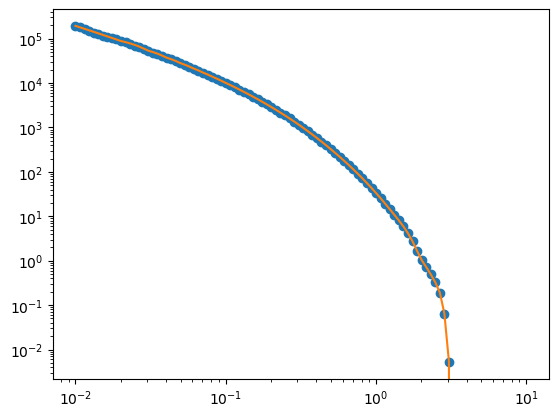

In [97]:
distance = np.loadtxt('%sData/Distance_13.txt' % folder)
w_w = np.loadtxt('%sData/Overlay_13.txt' % folder)
plt.loglog(distance, w_w, 'o')
plt.loglog(distance, np.loadtxt('%sData/EAM_13.txt' % folder))

Text(0.5, 1.0, 'Hydrogen-Helium Potential')

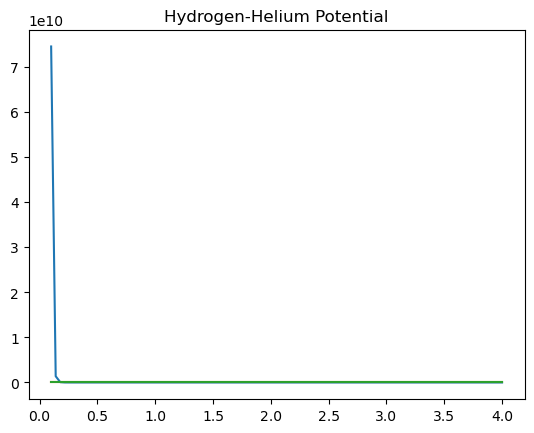

In [87]:
distance = np.loadtxt('%sData/Distance_23.txt' % folder)
w_he = np.loadtxt('%sData/Overlay_23.txt' % folder)

plt.plot(distance, w_he)

raw = np.zeros(distance.shape)

for idx,_r in enumerate(distance):
    raw[idx] = spline_H_He(_r, a)

plt.plot(distance, raw)
plt.plot(distance, ZBL(distance, 1, 2))

plt.title('Hydrogen-Helium Potential')

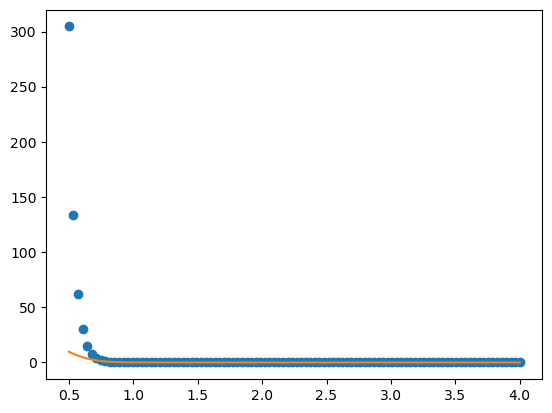

In [79]:
distance = np.loadtxt('%sData/Distance_23.txt' % folder)
w_w = np.loadtxt('%sData/Overlay_23.txt' % folder)
plt.plot(distance, w_w, 'o')
plt.plot(distance, np.loadtxt('%sData/EAM_23.txt' % folder))

Text(0.5, 1.0, 'Helium-Helium Potential')

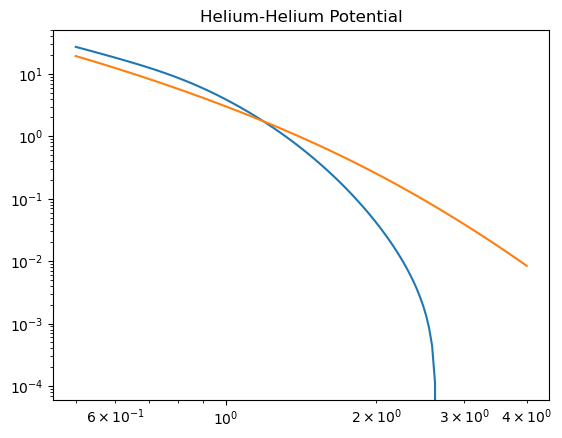

In [66]:
distance = np.loadtxt('%sData/Distance_33.txt' % folder)
w_he = np.loadtxt('%sData/Overlay_33.txt' % folder)

plt.loglog(distance, w_he)

raw = np.zeros(distance.shape)

for idx,_r in enumerate(distance):
    raw[idx] = spline_He_He(_r)

#plt.loglog(distance, raw)
plt.loglog(distance, ZBL(distance, 2, 2))
plt.title('Helium-Helium Potential')

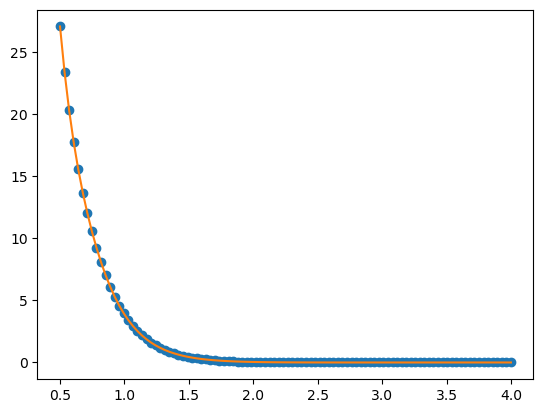

In [76]:
distance = np.loadtxt('%sData/Distance_33.txt' % folder)
w_w = np.loadtxt('%sData/Overlay_33.txt' % folder)
plt.plot(distance, w_w, 'o')
plt.plot(distance, np.loadtxt('%sData/EAM_33.txt' % folder))